# Artificial Intelligence Nanodegree
## Introductory Project: Diagonal Sudoku Solver

## Sudoku
Sudoku is a very popular puzzle. It consists of a 9x9 grid, and the objective is to fill the grid with digits in such a way that each row, each column, and each of the 9 principal 3x3 subsquares contains all of the digits from 1 to 9. The puzzle is given as a partially completed grid, and the goal is to fill in the missing numbers. 


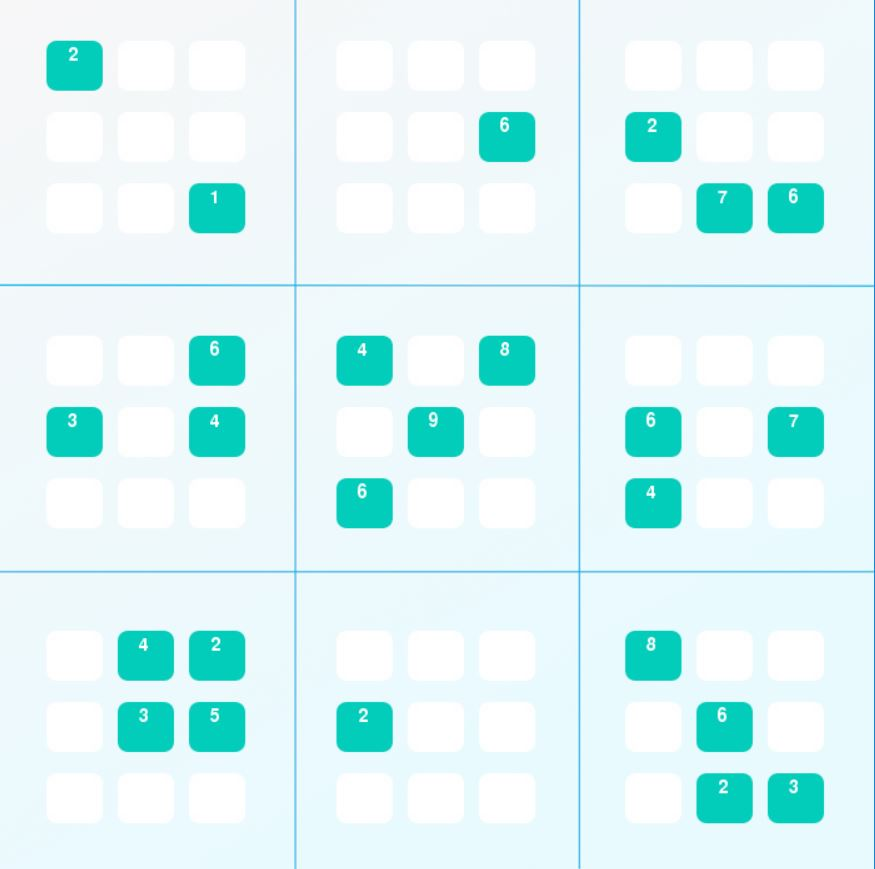

In [2]:
from IPython.display import Image
Image("Sudoku_start.jpg")

## Goals of this project
The goal is to use the Constraint Propagation and Search technique to build an intelligent agent that can solve sudoku.


### Setting up and encoding the board

In [3]:
# %load solution.py
assignments = []

def assign_value(values, box, value):
    """
    Please use this function to update your values dictionary!
    Assigns a value to a given box. If it updates the board record it.
    """

    # Don't waste memory appending actions that don't actually change any values
    if values[box] == value:
        return values

    values[box] = value
    if len(value) == 1:
        assignments.append(values.copy())
    return values


def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [s+t for s in A for t in B]

rows = 'ABCDEFGHI'
cols = '123456789'
boxes = cross(rows, cols)

row_units = [cross(r, cols) for r in rows]
column_units = [cross(rows, c) for c in cols]
square_units = [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')]
unitlist = row_units + column_units + square_units
units = dict((s, [u for u in unitlist if s in u]) for s in boxes)
peers = dict((s, set(sum(units[s],[]))-set([s])) for s in boxes)


def grid_values(grid):
    """
    Convert grid into a dict of {square: char} with '123456789' for empties.
    Args:
        grid(string) - A grid in string form.
    Returns:
        A grid in dictionary form
            Keys: The boxes, e.g., 'A1'
            Values: The value in each box, e.g., '8'. If the box has no value, then the value will be '123456789'.
    """
    values = []
    all_digits = '123456789'
    for c in grid:
        if c == '.':
            values.append(all_digits)
        elif c in all_digits:
            values.append(c)
    assert len(values) == 81
    return dict(zip(boxes, values))


def display(values):
    """
    Display the values as a 2-D grid.
    Args:
        values(dict): The sudoku in dictionary form
    """
    width = 1+max(len(values[s]) for s in boxes)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(values[r+c].center(width)+('|' if c in '36' else '')
                      for c in cols))
        if r in 'CF': 
            print(line)
    print



## Technique 1: Constraint Propagation
Constraint Propagation is using local constraints in a space to dramatically reduce the search space.

### Strategy 1: Elimination
If a box has a value assigned, then none of the peers of this box can have this value.


In [4]:
def eliminate(values):
    """
    Go through all the boxes, and whenever there is a box with a value, eliminate this value from 
    the values of all its peers.
    Input: A sudoku in dictionary form.
    Output: The resulting sudoku in dictionary form.
    """
    solved_values = [box for box in values.keys() if len(values[box]) == 1]
    for box in solved_values:
        digit = values[box]
        for peer in peers[box]:
            #values[peer] = values[peer].replace(digit,'')
            values = assign_value(values, peer, values[peer].replace(digit,''))
    return values



### Strategy 2: Only Choice
If there is only one box in a unit which would allow a certain digit, then that box must be assigned that digit.

In [5]:
def only_choice(values):
    """
    Go through all the units, and whenever there is a unit with a value that only fits in one box, 
    assign the value to this box.
    Input: A sudoku in dictionary form.
    Output: The resulting sudoku in dictionary form.
    """
    for unit in unitlist:
        for digit in '123456789':
            dplaces = [box for box in unit if digit in values[box]]
            if len(dplaces) == 1:
                #values[dplaces[0]] = digit
                values = assign_value(values, dplaces[0], digit)
    return values


### Strategy 3: Naked Twins
When a boz contains two possible values only and it has a peer that contains the same two possible values, they are a twins and these possible values should be hold by these two boxes only. Thus, these two possible values can be eliminated from the values of their common peers.

In [6]:
def naked_twins(values):
    """Eliminate values using the naked twins strategy.
    Args:
        values(dict): a dictionary of the form {'box_name': '123456789', ...}

    Returns:
        the values dictionary with the naked twins eliminated from peers.
    """

    # Find all instances of naked twins
    potential_twins = [box for box in values.keys() if len(values[box]) == 2]

    # Twins that have the same elements
    naked_twins = [[box,twin] for box in potential_twins for twin in peers[box] 
                   if (values[box] == values[twin])]
    
    # Eliminate the naked twins as possibilities for their peers
    for twins in naked_twins:
        twin1_peers = peers[twins[0]]
        twin2_peers = peers[twins[1]]
        
        twins_peers = []
        for peer_twin1 in twin1_peers:
            if peer_twin1 in twin2_peers:
                twins_peers.append(peer_twin1)
                    
        digits = values[twins[0]]
            
        for digit in digits:
            for peer in twins_peers:
                values[peer] = values[peer].replace(digit,'')
                            
    return values

### Strategy 4: Diagonal Sudoku
Among the two main diagonals, the numbers 1 to 9 should all appear exactly one time only. If these are boxes on the diagonals that contain only one value, these values can be eliminated from the values of other boxes within the same diagonal.

In [7]:
diagonal1 = [[r + c for (r, c) in zip(rows, cols)]]
diagonal2 = [[r + str(10 - int(c)) for (r, c) in zip(rows, cols)]]

# update the unitlist
unitlist = row_units + column_units + square_units + diagonal1 + diagonal2

### Combining the strategies (functions) together

In [8]:
def reduce_puzzle(values):
    """
    Iterate eliminate() and only_choice(). If at some point, there is a box with no available values, return False.
    If the sudoku is solved, return the sudoku.
    If after an iteration of both functions, the sudoku remains the same, return the sudoku.
    Input: A sudoku in dictionary form.
    Output: The resulting sudoku in dictionary form.
    """
    solved_values = [box for box in values.keys() if len(values[box]) == 1]
    stalled = False
    while not stalled:
        solved_values_before = len([box for box in values.keys() if len(values[box]) == 1])
        values = eliminate(values)
        values = only_choice(values)
        values = naked_twins(values)
        solved_values_after = len([box for box in values.keys() if len(values[box]) == 1])
        stalled = solved_values_before == solved_values_after
        if len([box for box in values.keys() if len(values[box]) == 0]):
            return False
    return values

## Technique 2: Search
Pick a box with a minimal number of possible values. Try to solve each of the puzzles obtained by choosing each of these values, recursively.

In [9]:
def search(values):
    "Using depth-first search and propagation, try all possible values."
    # First, reduce the puzzle using the previous function
    values = reduce_puzzle(values)
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in boxes): 
        return values ## Solved!
    # Choose one of the unfilled squares with the fewest possibilities
    n,s = min((len(values[s]), s) for s in boxes if len(values[s]) > 1)
    # Now use recurrence to solve each one of the resulting sudokus, and 
    for value in values[s]:
        new_sudoku = values.copy()
        new_sudoku[s] = value
        attempt = search(new_sudoku)
        if attempt:
            return attempt

## Time for the intelligent agent to solve the Sudoku

In [10]:
def solve(grid):
    """
    Find the solution to a Sudoku grid.
    Args:
        grid(string): a string representing a sudoku grid.
            Example: '2.............62....1....7...6..8...3...9...7...6..4...4....8....52.............3'
    Returns:
        The dictionary representation of the final sudoku grid. False if no solution exists.
    """
    values = grid_values(grid)
    return search(values)


if __name__ == '__main__':
    diag_sudoku_grid = '2.............62....1....7...6..8...3...9...7...6..4...4....8....52.............3'
    display(solve(diag_sudoku_grid))

    try:
        from visualize import visualize_assignments
        visualize_assignments(assignments)

    except SystemExit:
        pass
    except:
        #print('We could not visualize your board due to a pygame issue. Not a problem! It is not a requirement.')
        pass

2 6 7 |9 4 5 |3 8 1 
8 5 3 |7 1 6 |2 4 9 
4 9 1 |8 2 3 |5 7 6 
------+------+------
5 7 6 |4 3 8 |1 9 2 
3 8 4 |1 9 2 |6 5 7 
1 2 9 |6 5 7 |4 3 8 
------+------+------
6 4 2 |3 7 9 |8 1 5 
9 3 5 |2 8 1 |7 6 4 
7 1 8 |5 6 4 |9 2 3 


## Step 1: The Sudoku puzzle

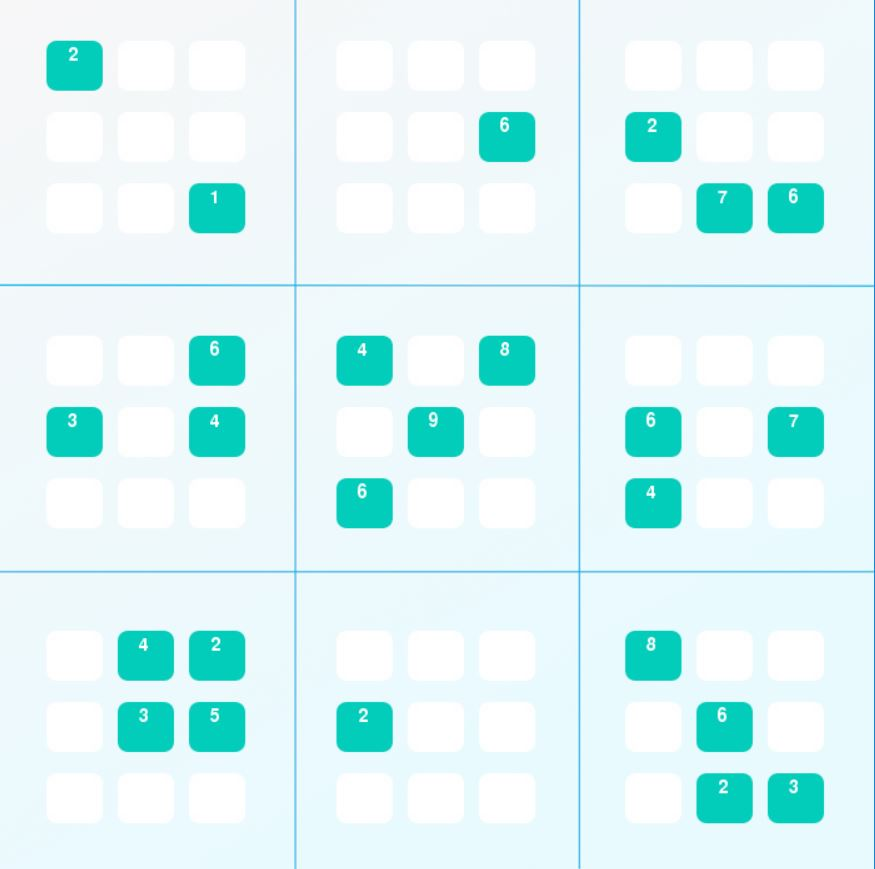

In [13]:
Image("Sudoku_start.jpg")


## Step 2: Solving

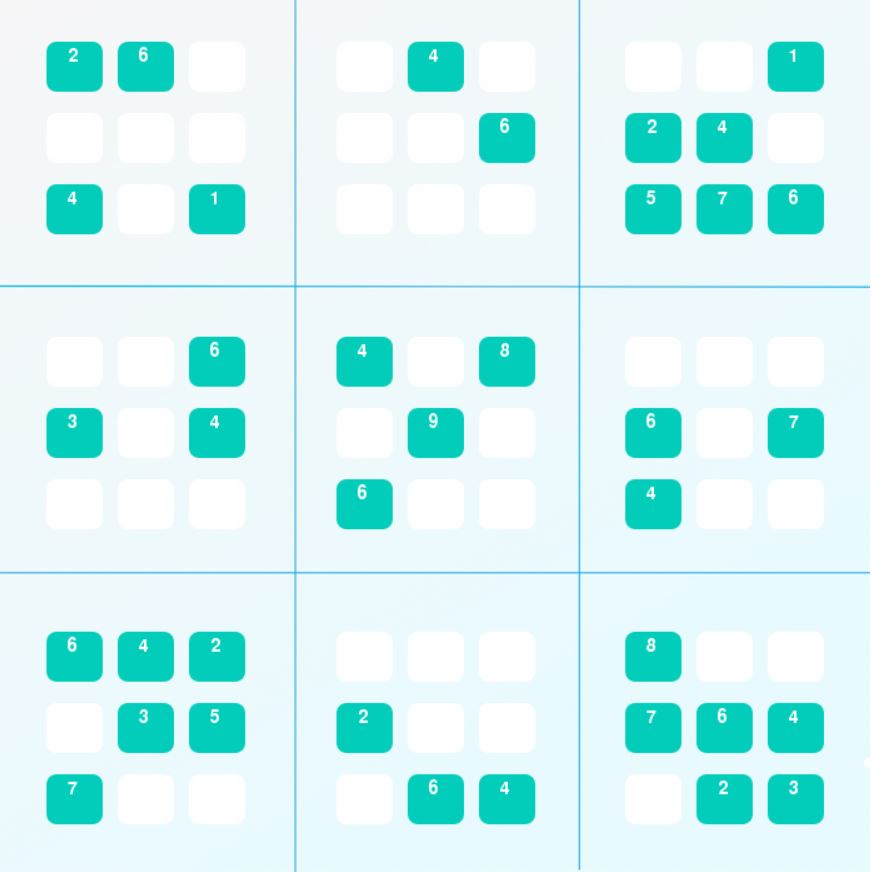

In [14]:
Image("Sudoku_working.jpg")


## Step 3: Sloved!

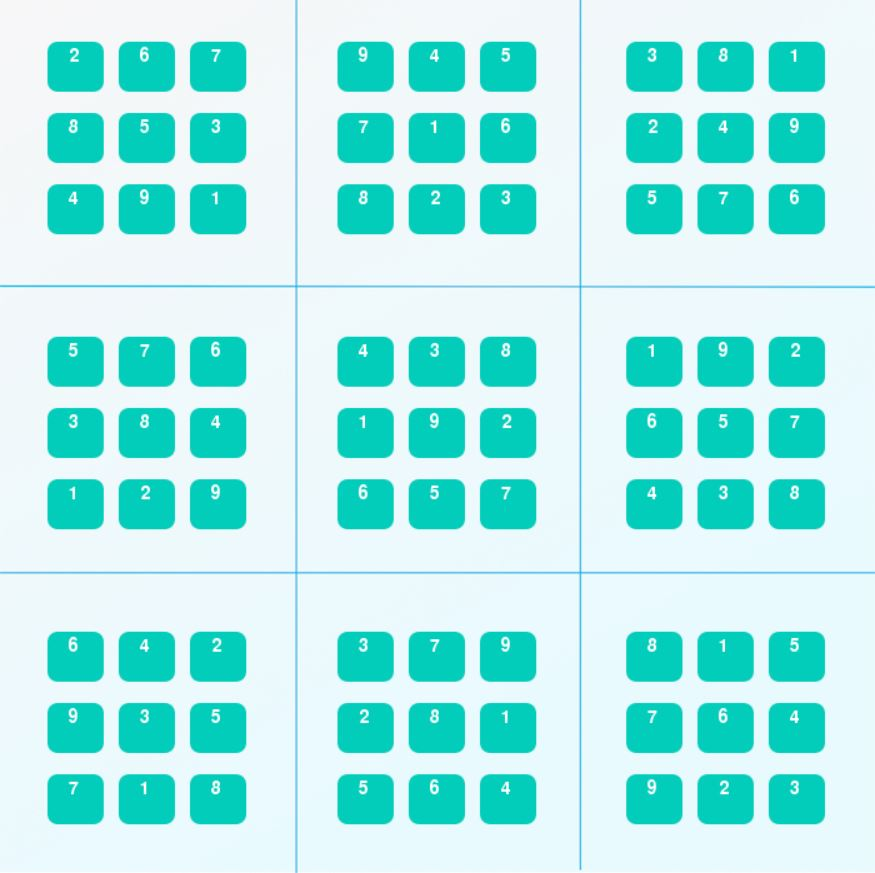

In [15]:
Image("Sudoku_finished.jpg")
